In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights

from sklearn.metrics import f1_score, precision_score, recall_score

from PIL import Image
import os
import numpy as np

In [14]:
class ConfigVit:
    img_size = 224
    batch_size = 16
    lr = 3e-5
    weight_decay = 0.01
    epochs = 8          # 5–10 recommandé
    num_classes = 38

TRAIN_DIR = r"C:\Users\ENNHILI YASSINE\Desktop\ASMAE-ABDELOUAFI\train"
VAL_DIR   = r"C:\Users\ENNHILI YASSINE\Desktop\ASMAE-ABDELOUAFI\val"
TEST_DIR  = r"C:\Users\ENNHILI YASSINE\Desktop\ASMAE-ABDELOUAFI\test"

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
train_transform_vit = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(ConfigVit.img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(25),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform_vit = transforms.Compose([
    transforms.Resize((ConfigVit.img_size, ConfigVit.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [16]:
class SimpleLeafDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform

        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        self.samples = []
        for cls in self.classes:
            cls_folder = os.path.join(root_dir, cls)
            for f in os.listdir(cls_folder):
                if f.lower().endswith((".jpg", ".jpeg", ".png")):
                    self.samples.append(
                        (os.path.join(cls_folder, f), self.class_to_idx[cls])
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        return img, label

In [17]:
train_ds = SimpleLeafDataset(TRAIN_DIR, train_transform_vit)
val_ds   = SimpleLeafDataset(VAL_DIR,   val_transform_vit)
test_ds  = SimpleLeafDataset(TEST_DIR,  val_transform_vit)

train_loader = DataLoader(train_ds, batch_size=ConfigVit.batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=ConfigVit.batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=ConfigVit.batch_size, shuffle=False)

print("Train:", len(train_ds))
print("Val:  ", len(val_ds))
print("Test: ", len(test_ds))
print("Classes:", len(train_ds.classes))

Train: 25617
Val:   8129
Test:  5417
Classes: 38


In [18]:
model_vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

# remplacer la tête
in_dim = model_vit.heads.head.in_features
model_vit.heads.head = nn.Linear(in_dim, ConfigVit.num_classes)

model_vit = model_vit.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_vit.parameters(),
                        lr=ConfigVit.lr,
                        weight_decay=ConfigVit.weight_decay)

print("ViT prêt.")

ViT prêt.


In [19]:
def evaluate_vit(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    return {
        "accuracy": (all_preds == all_labels).mean(),
        "f1_macro": f1_score(all_labels, all_preds, average="macro"),
        "precision_macro": precision_score(all_labels, all_preds, average="macro"),
        "recall_macro": recall_score(all_labels, all_preds, average="macro"),
    }

In [20]:
best_acc = 0
best_model_path = "vit_finetuned_best.pth"

for epoch in range(ConfigVit.epochs):
    model_vit.train()
    train_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model_vit(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    metrics = evaluate_vit(model_vit, val_loader)

    print(f"\nEpoch {epoch+1}/{ConfigVit.epochs}")
    print(f"Loss: {train_loss/len(train_loader):.4f}")
    print(f"Val Acc: {metrics['accuracy']*100:.2f} %")
    print(f"Val F1 : {metrics['f1_macro']:.4f}")

    # Sauvegarde du meilleur modèle
    if metrics["accuracy"] > best_acc:
        best_acc = metrics["accuracy"]
        torch.save(model_vit.state_dict(), best_model_path)
        print("🔥 Nouveau meilleur modèle sauvegardé !")

C:\Users\ENNHILI YASSINE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Epoch 1/8
Loss: 0.2541
Val Acc: 89.09 %
Val F1 : 0.8391
🔥 Nouveau meilleur modèle sauvegardé !


C:\Users\ENNHILI YASSINE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Epoch 2/8
Loss: 0.0612
Val Acc: 89.00 %
Val F1 : 0.8412


C:\Users\ENNHILI YASSINE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Epoch 3/8
Loss: 0.0453
Val Acc: 90.43 %
Val F1 : 0.8545
🔥 Nouveau meilleur modèle sauvegardé !


C:\Users\ENNHILI YASSINE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Epoch 4/8
Loss: 0.0363
Val Acc: 92.02 %
Val F1 : 0.8584
🔥 Nouveau meilleur modèle sauvegardé !


C:\Users\ENNHILI YASSINE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Epoch 5/8
Loss: 0.0343
Val Acc: 90.82 %
Val F1 : 0.8535


C:\Users\ENNHILI YASSINE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Epoch 6/8
Loss: 0.0307
Val Acc: 90.43 %
Val F1 : 0.8472


C:\Users\ENNHILI YASSINE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Epoch 7/8
Loss: 0.0265
Val Acc: 91.91 %
Val F1 : 0.8666

Epoch 8/8
Loss: 0.0257
Val Acc: 90.88 %
Val F1 : 0.8546


C:\Users\ENNHILI YASSINE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [21]:
model_vit.load_state_dict(torch.load("vit_finetuned_best.pth", map_location=device))
model_vit.eval()

metrics_test = evaluate_vit(model_vit, test_loader)

print("\n===== Résultats ViT fine-tuné =====")
print(f"Accuracy : {metrics_test['accuracy']*100:.2f}%")
print(f"F1-macro : {metrics_test['f1_macro']:.4f}")
print(f"Précision: {metrics_test['precision_macro']:.4f}")
print(f"Rappel   : {metrics_test['recall_macro']:.4f}")

C:\Users\ENNHILI YASSINE\AppData\Local\Temp\ipykernel_19632\1321312882.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vit.load_state_dict(torch.load("vit_finetune


===== Résultats ViT fine-tuné =====
Accuracy : 91.95%
F1-macro : 0.8562
Précision: 0.8255
Rappel   : 0.9086


C:\Users\ENNHILI YASSINE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [23]:
def evaluate_vit(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Convertir en numpy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    return {
        "accuracy": (all_preds == all_labels).mean(),
        "f1_macro": f1_score(all_labels, all_preds, average="macro"),
        "precision_macro": precision_score(all_labels, all_preds, average="macro", zero_division=0),
        "recall_macro": recall_score(all_labels, all_preds, average="macro", zero_division=0),

        # Ces deux-là sont ESSENTIELS pour la matrice de confusion
        "preds": all_preds,
        "labels": all_labels
    }


C:\Users\ENNHILI YASSINE\AppData\Local\Temp\ipykernel_19632\3375259914.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(vit_path, map_location=device)

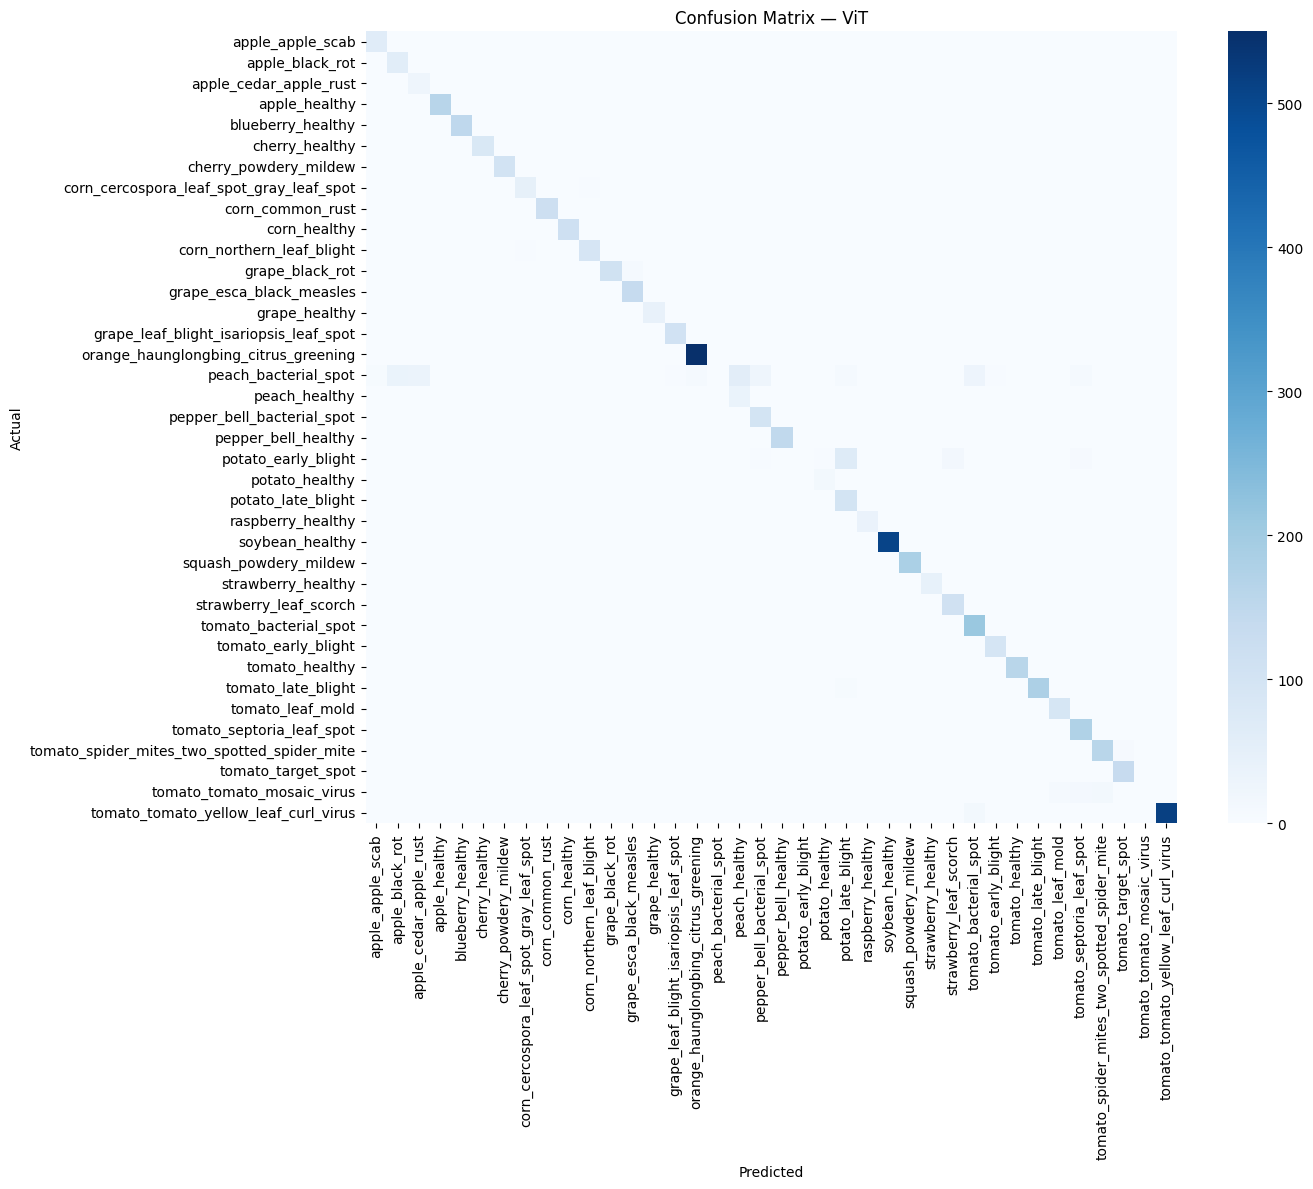

✅ Matrice de confusion générée et enregistrée sous : confusion_matrix_vit.png


In [28]:
# =============================== 
# MATRICE DE CONFUSION DIRECTE — ViT
# ===============================
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Charger poids
vit_path = r"C:\Users\ENNHILI YASSINE\Desktop\ASMAE-ABDELOUAFI\CV_Project\vit_finetuned_best.pth"

state = torch.load(vit_path, map_location=device)
model_vit.load_state_dict(state)
model_vit.eval()

# 2. Prédictions complètes
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model_vit(x)
        preds = out.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 3. Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=test_ds.classes,
    yticklabels=test_ds.classes
)
plt.title("Confusion Matrix — ViT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

plt.savefig("confusion_matrix_vit.png", dpi=300)
plt.show()

print("✅ Matrice de confusion générée et enregistrée sous : confusion_matrix_vit.png")